In [ ]:
!pip install -q -U albumentations

In [ ]:
!pip install dash

# Install above imports and Gdrive auth


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab.patches import cv2_imshow
import sys
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

import glob
import pathlib
from tqdm import tqdm
import re
import os
import shutil
import random
#Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output
from matplotlib import pyplot as plt
import cv2
import seaborn as sns


import numpy as np
import pandas as pd
from math import sqrt
from google.colab.patches import cv2_imshow
#import splitfolders

# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

#Augmentations
import albumentations as A

# Unique IDS
import uuid

%matplotlib inline


start_data = '/content/drive/MyDrive/ColabNotebooks/Datas/plantvillage-dataset/color/'
base_path=None


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Parsing of the path and creating the DataFrame


*   Fuction ***extract_plant_names*** seperates the Folder string names      into 2 new Series based on a **regex** pattern:

  *   Plants
  *   Sudirectory Names: Disease or Healty

* Function __clasify_folders__ that classifies folder depended on the mean value:
  *   Above mean
  *   Below mean
  *   Risk


*   Dictionary that retrives the orignal *strings* and *path files*
*   DataFrame that includes:

  *   Original Folder names
  *   File distribution of each folder ( Int )
  *   Plant Name
  *   Sudirectory Names
  *   Category based on a value


  







The prase of the starting location `root` can be one almsot 1 liner

```
# for files - files = [f for f in pathlib.Path().iterdir() if f.is_file()]
# for folders - files = [f for f in pathlib.Path().iterdir() if f.is_dir()]
```




In [ ]:
def extract_plant_names(folder_names, pattern):
    """
    Extract plant names from folder names using a regex pattern.
    Alerts for any unmatched folder names.

    Parameters:
        folder_names (list): List of folder names to process.
        pattern (str): Regex pattern to extract plant names.

    Returns:
        plant_names (list): List of extracted plant names.
        sub_names (list): List of the folder names with out the plant string.
    """
    plant_names = []
    unmatched = []
    sd_names = []

    for folder in folder_names:
        match = re.match(pattern, folder)
        if match:
            plant_name = match.group(1)
            sd_name = folder.split("___")[1]  # Assuming "___" separates the plant and the second name
            plant_names.append(plant_name)
            sd_names.append(sd_name)
        else:
            plant_names.append("Unknown")
            sd_names.append("Unknown")
            unmatched.append(plant_names)

    # Alert for unmatched folder names
    if unmatched:
        print("⚠️ Alert: The following folder names did not match the expected pattern:")
        for folder in unmatched:
            print(f"- {folder}")

    return plant_names,sd_names

In [ ]:
def classify_folders(counts):
    """
    Categorizes numerical counts into:
      - 'Above_mean' (counts => mean)
      - 'Below_mean' (half_mean ≤ counts ≤ mean)
      - 'Risk' (counts < half_mean)

    Returns a NumPy array of category labels.
    """
    mean_value = int(counts.mean())
    half_mean = mean_value // 2  # Ensure integer division consistency


    print(f"Mean: {mean_value}, Half Mean: {half_mean}")

    return np.select(
        [counts >= mean_value, counts >= half_mean],
        ["Above_mean", "Below_mean"],
        default="Risk"
    )


In [ ]:
p = pathlib.Path(start_data)
dist_files = {
    folder.name: [file for file in folder.iterdir()]
    for folder in p.iterdir() if folder.is_dir()
}

# Create DataFrame
# df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dist_files.items()]))
# df = df.reset_index(drop=True)

# Count files in each folder
folder_counts = pd.DataFrame({'Folder': dist_files.keys(), 'Counts': [len(v) for v in dist_files.values()]})

# Extract plant names
pattern = r'^([^_]+)'
folder_counts['Plants'] ,folder_counts['Sub']= extract_plant_names(folder_counts['Folder'], pattern)

folder_counts["MeanCategory"] = classify_folders(folder_counts["Counts"])
folder_counts.head(5)

Mean: 1212, Half Mean: 606


,Folder,Counts,Plants,Sub,MeanCategory
0,Cherry_(including_sour)___Powdery_mildew,1052,Cherry,Powdery_mildew,Below_mean
1,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513,Corn,Cercospora_leaf_spot Gray_leaf_spot,Risk
2,Corn_(maize)___Common_rust_,1192,Corn,Common_rust_,Below_mean
3,Corn_(maize)___Northern_Leaf_Blight,985,Corn,Northern_Leaf_Blight,Below_mean
4,Corn_(maize)___healthy,1162,Corn,healthy,Below_mean


In [ ]:
# print(folder_counts.info(),"",folder_counts.describe())
# print(folder_counts.head(3))


In [ ]:
remove=['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus',
        'Apple___Cedar_Rust','Tomato___Tomato_mosaic_virus','Potato___Early_blight','Potato___Late_blight','Potato___healthy']

# fldoer_counts = folder_counts.drop(columns=[key for key in remove if key in folder_counts])
final=folder_counts.drop(folder_counts[folder_counts['Folder'].isin(remove)].index)
final.reset_index(drop=True, inplace=True)

print(final.info(),"",final.describe())
print(final.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Folder        26 non-null     object
 1   Counts        26 non-null     int64 
 2   Plants        26 non-null     object
 3   Sub           26 non-null     object
 4   MeanCategory  26 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.1+ KB
None              Counts
count    26.000000
mean   1205.000000
std     509.894499
min     360.000000
25%     960.250000
50%    1135.500000
75%    1562.750000
max    2297.000000
                                     Folder  Counts  Plants  \
0  Cherry_(including_sour)___Powdery_mildew    1052  Cherry   
1               Corn_(maize)___Common_rust_    1192    Corn   
2       Corn_(maize)___Northern_Leaf_Blight     985    Corn   

                    Sub MeanCategory  
0        Powdery_mildew   Below_mean  
1          Common_rust_   Below_mean  
2  Nort

In [ ]:
mean_value = int(final["Counts"].mean())

# Anything that is" not in Risk will have 100 items the rest will be 200 items for validation and test
final["split_size"] = np.where(final["MeanCategory"] != "Risk", 200, 100)

# Compute the number of images available for training after the split
final["train_files"] = final["Counts"] - (final["split_size"]*2)
# we cut down the Above_mean category
final.loc[final["MeanCategory"] == "Above_mean", "train_files"] = mean_value // 2

# Compute the number of images that we need to compensate with augmentation
final["Augment_Needed"] = np.maximum(0, mean_value - final["train_files"])

# Compute the number of distinct images required for augmentation (rounded up)
final["original_files"] = np.ceil(final["Augment_Needed"] / 15).astype(int)

# FIxing the dataset imbalance

At first we have an over view of the description and info of our final dataset.

* We split the dataset based on the previous metric columns and we prepare the 4 dictionaries that hold as key,value pairs the **Folder Names** and the corresponding **image paths** .

* We create the folder structure that we want and populate the folders by copying or moving the image files. Those responsible of augmentation are fed to our function and create new augmented images **(15 x per img)+1 the original**.


---

For example:

The Final Amount that we want to achieve :  **31330**   
Amount of the original files for Augmentation: 1154         
Amount after the split and before Augmentation :  **14269**        
Amount of images we need to compasate with Augmentation : **17061**


---
Train size: **20376**  
Augmented:  **1154**   
Validation & Test:  **4900 x 2**

---





In [ ]:
p=r"/content/drive/MyDrive/ColabNotebooks/Final_thesis_code/data_stats.csv"
final.to_csv(p)

In [ ]:
# Create stats of the dataset
print(final.info(),"",final.describe())
print(final.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Folder          26 non-null     object
 1   Counts          26 non-null     int64 
 2   Plants          26 non-null     object
 3   Sub             26 non-null     object
 4   MeanCategory    26 non-null     object
 5   split_size      26 non-null     int64 
 6   train_files     26 non-null     int64 
 7   Augment_Needed  26 non-null     int64 
 8   original_files  26 non-null     int64 
dtypes: int64(5), object(4)
memory usage: 2.0+ KB
None              Counts  split_size  train_files  Augment_Needed  original_files
count    26.000000   26.000000    26.000000       26.000000       26.000000
mean   1205.000000  188.461538   548.807692      656.192308       44.384615
std     509.894499   32.581259   179.580850      179.580850       11.886385
min     360.000000  100.000000   160.000000      413.0

In [ ]:
print("The total Amount of all files files :  ",(final["Augment_Needed"] + final["train_files"]).sum(),"Amount that have reached the value ")
print("Amount of the original files for Augmentation:",final.original_files.sum())

print("Amount after the split of train and test and before Augmentation : ",final.train_files.sum())
print("Amount of images we need to compasate with Augmentation :",final.Augment_Needed.sum())

The total Amount of all files files :   31330 Amount that have reached the value 
Amount of the original files for Augmentation: 1154
Amount after the split of train and test and before Augmentation :  14269
Amount of images we need to compasate with Augmentation : 17061


In [ ]:
train, validation, test, aug_train = {}, {}, {}, {}

# Function to distribute images efficiently
def distribute_images(folder_name, file_list, split_size, distinct_aug_sources):
    """
    Efficiently distributes images into train, validation, and test sets.
    Uses precomputed augmentation values and minimizes memory overhead.
    """
    random.shuffle(file_list)  # Shuffle to ensure randomness

    # Allocate test and validation sets based on split_size
    test[folder_name], file_list = file_list[:split_size], file_list[split_size:]

    validation[folder_name], file_list = file_list[:split_size], file_list[split_size:]


    # Reserving original images for augmentation
    aug_train[folder_name], file_list = file_list[:distinct_aug_sources], file_list[distinct_aug_sources:]

    # the remaining amount of the file list
    train[folder_name]=file_list


# Process each folder using precomputed values from folder_counts
for _, row in final.iterrows():
    folder = row["Folder"]
    available_files = dist_files.get(folder, [])

    # Extract necessary values
    split_size = row["split_size"]  # Now dynamically assigned per category
    distinct_aug_sources = int(row["original_files"])  # Available distinct images
    # For each key : Folder Name
    distribute_images(folder, available_files, split_size, distinct_aug_sources)

print(f"Train size: {len(train)} and {sum(len(v) for v in train.values())}")
print(f"Augmented: {len(aug_train)} and {sum(len(v) for v in aug_train.values())}")
print(f"Validation size: {len(validation)} and {sum(len(v) for v in validation.values())}")
print(f"Test size: {len(test)} and {sum(len(v) for v in test.values())}")


Train size: 26 and 20376
Augmented: 26 and 1154
Validation size: 26 and 4900
Test size: 26 and 4900


In [ ]:
for k,v in aug_train.items():
  print(k,len(v))

Cherry_(including_sour)___Powdery_mildew 37
Corn_(maize)___Common_rust_ 28
Corn_(maize)___Northern_Leaf_Blight 42
Corn_(maize)___healthy 30
Grape___Black_rot 29
Grape___Esca_(Black_Measles) 41
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 36
Grape___healthy 66
Peach___Bacterial_spot 41
Peach___healthy 70
Pepper,_bell___Bacterial_spot 41
Pepper,_bell___healthy 41
Strawberry___Leaf_scorch 34
Strawberry___healthy 64
Tomato___Bacterial_spot 41
Tomato___Early_blight 41
Tomato___Late_blight 41
Tomato___Leaf_Mold 44
Tomato___Septoria_leaf_spot 41
Tomato___Spider_mites Two-spotted_spider_mite 41
Tomato___Target_Spot 41
Tomato___healthy 41
Apple___Apple_Scab 65
Apple___Black_Rot 66
Apple___Healthy 41
Cherry_(including_sour)___Healthy 51


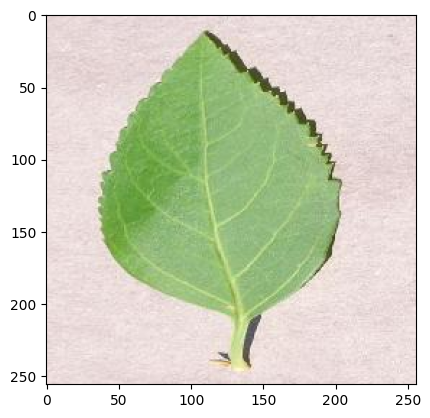

In [ ]:
aug_train.items()
for k,v in aug_train.items():
  a=cv2.imread(v[14],cv2.IMREAD_COLOR_RGB)
  plt.imshow(a)


In [ ]:
weather = A.Compose([
     A.RandomSnow(brightness_coeff=1.7,  snow_point_range= (0.3,0.5),p=0.5),
     A.RandomRain(brightness_coefficient=0.8, drop_width=2, blur_value=3, p=0.5)
 ])

light = A.Compose([
    # A. RandomBrightnessContrast(brightness_limit=(-0.23,0.35),p=0.5),
    A.GridDropout(ratio=0.3,p=0.5),
    A.MultiplicativeNoise(multiplier=(0.97,2.30),elementwise=True,per_channel=True,p=0.5)
])

geometric = A.Compose([
     A.CLAHE(p=1),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)

])

def Augs(img):
  img=cv2.imread(img, cv2.IMREAD_COLOR_RGB)
  aug_img_list=[]
  aug_img_list.append(img)
  sshape=img.shape

  for _ in range(5):
    w=weather(image=img)['image']
    l=light(image=img)['image']
    g=geometric(image=img)['image']
    for i in [w,l,g]:
      if i.shape != sshape: i.reshape(sshape)
      aug_img_list.append(i)
  return aug_img_list


In [ ]:
def process_images(dataset_dict, base_path, dataset_type, augment=None):
    for folder_name, image_paths in dataset_dict.items():
      # Take each folder_name and check if we have a folder
      folder_path = os.path.join(base_path, dataset_type, folder_name)
      os.makedirs(folder_path, exist_ok=True)
      # Take any image path of each folder_name and copy paste
      for image_path in image_paths:
          dest_path = os.path.join(folder_path, os.path.basename(image_path))
          shutil.copy(image_path, dest_path)

    if augment is not None:
      for k,v in augment.items():
        folder_path = os.path.join(base_path, dataset_type, k)
        for img_path in v:
          aug_list = Augs(img_path)
          for aug_img in aug_list:
              filename = os.path.join(folder_path, f"{uuid.uuid4().hex[:10]}.jpg")
              cv2.imwrite(filename, aug_img)
process_images(train, base_path, "train", augment=aug_train)
process_images(validation, base_path, "validation")
process_images(test, base_path, "test")

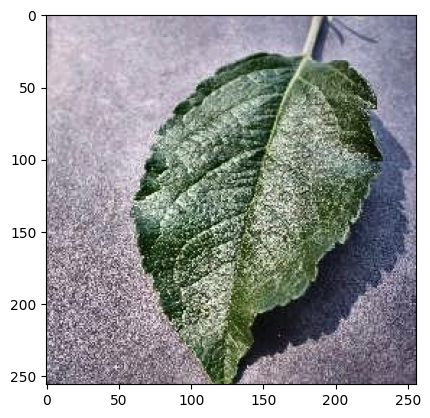

In [ ]:
check=r"/content/check"
p = pathlib.Path(check)
temp_dict = {
    folder.name: [file for file in folder.iterdir()]
    for folder in p.iterdir() if folder.is_dir()
}
for k,v in temp_dict.items():
  plt.imshow(cv2.imread(v[0]))
# # Count files in each folder
# count_check = pd.DataFrame({'Folder': temp_dict.keys()}, {'Counts': [len(v) for v in temp_dict.values()]})
# # comparison_df = count_check.merge(final[["Folder", "Augment_Needed"]], on="Folder", how="outer")
# # comparison_df

# Graphs for the dataset

Visualize metrics that have been compiled and answer the below questions.

**Nature of our data**

1.   How many Plant species do we have?
2.   How many categories for each Plant?
3.   How many files for each category and Plant?

---

1.   How many are Above, Below the mean value or At Risk?

> At risk is anything that is below half of the mean

2.   How many files do i need to compasate with Augmentation to reach the amount for each folder?








In [ ]:
data=pd.read_csv(r"/content/drive/MyDrive/ColabNotebooks/Final_thesis_code/Saved_models_and_csv/data_stats.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)
data.head(3)

,Folder,Counts,Plants,Sub,MeanCategory,split_size,train_files,Augment_Needed,original_files
0,Cherry_(including_sour)___Powdery_mildew,1052,Cherry,Powdery_mildew,Below_mean,200,652,553,37
1,Corn_(maize)___Common_rust_,1192,Corn,Common_rust_,Below_mean,200,792,413,28
2,Corn_(maize)___Northern_Leaf_Blight,985,Corn,Northern_Leaf_Blight,Below_mean,200,585,620,42


In [ ]:
plant_colors = {
    "Apple": "#8DB600",
    "Cherry": "#D2042D",
    "Corn": "#FFD700",
    "Grape": "#800080",
    "Peach": "#FBC490",
    "Pepper,": "#8B4513",
    "Strawberry": "#EE1E52",
    "Tomato": "#FF6347"
}


In [ ]:
def plot_file_distribution(df):
    """
    Creates a Plotly visualization with
      1* a Bar chart to show case the files before the split,
      2* Scatter plot that has (x) as points of the files after the split,
      3* Wave effect with the volume of images in need to reach the value with augmentation.

    of file distribution across categories,
    grouped by plant names with trend lines and wave effects for MeanCategory.

    Parameters:
        df (pd.DataFrame): DataFrame with columns
        [
        'Counts' --> files before the split, 'Plants',
        'MeanCategory' --> Category based on value *this case the mean value*,
        "train_files" --> files after the split].
        "Augmented_Needed" --> compasation with augmened images to reach the value
        "original_files" --> original images that used for augmentation ]
    Returns:
        None (displays the interactive Plotly figure)
    """

    # Compute mean and half-mean
    mean_count = int(df["Counts"].mean())
    # Sort DataFrame by Plant Name
    df_sorted = df.sort_values(by="Plants")

    # Create base bar chart for Original Counts (Grouped by Plant)
    fig = px.bar(df_sorted,
             x="Folder",
             y="train_files",
             color="Plants",  # Color mapped to 'Plants'
             title=f"File Distribution Across Folders (Grouped by Plant)<br>Mean: {mean_count}, Half of Mean: {int(mean_count/2)}",
             labels={"Folder": "Disease", "Counts": "File Count"},
             color_discrete_map=plant_colors
             )


    fig.add_trace(go.Bar(
        x=df_sorted["Folder"],
        y=df_sorted["Counts"],
        name="Files Before Split",
        marker=dict(
            color="white",  # White background
            pattern=dict( # Diagonal cross-hatch (striped effect)
                fgcolor="red",  # Red stripes
                bgcolor="white"  # White background
            )
        )
    ))

    # Define colors for each MeanCategory
    category_colors = {"Risk": "red", "Above_mean": "blue", "Below_mean": "green"}

    # Plot separate lines for each MeanCategory with wave effect
    for category, color in category_colors.items():
        subset = df_sorted[df_sorted["MeanCategory"] == category]

        fig.add_trace(go.Scatter(
            x=subset["Folder"],
            y=subset["train_files"],  # Using train_files to show remaining after split
            mode="lines+markers",
            marker=dict(size=10, symbol="x"),
            line=dict(color=color, width=3),
            hoverinfo="text",
            text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(df["Augment_Needed"], df["Plants"],df["Sub"])],
            name=f"{category} Trend"
        ))

    fig.add_trace(go.Scatter(
        x=df_sorted["Folder"],
        y=df_sorted["Augment_Needed"],
        fill="tozeroy",  # Fill area under the line
        mode="lines",  # Keep the outline of the fill
        line=dict(width=1),  # No line on top of fill
        fillcolor="rgba(0, 100, 255, 0.3)",  # Light blue transparent fillhoverinfo="text",
        text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(df_sorted["Augment_Needed"], df_sorted["Plants"],df_sorted["Sub"])],
        name="Augmentation Wave",
        visible="legendonly"))

    # Update Layout for Readability
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis=dict(
            tickmode="array",
            tickvals=list(range(len(df_sorted["Folder"]))),
            ticktext=df_sorted["Sub"]
        ),
        showlegend=True,
        title_x=0.5,
        height=700,
        width=1200,
        barmode="relative",
    )

    # Show figure
    fig.show()
plot_file_distribution(data)

In [ ]:
def plot_file_aug(df):
  '''
  Creates a Plotly visualization of
    1* Bar chart with the Original files after the split.
    2* Scatter plot that has (x) and wave effect to showcase the amount of images
        through augmentation that we need to compasate
    3* Scatter plot with bold line to show case how many original images have been used for the augmentation.
  '''
  folder_counts_sorted = df.sort_values(by="Plants")
# Create base bar chart for Original Counts
  fig = px.bar(folder_counts_sorted,
              x="Folder",
              y="train_files",
              color="Plants",
              title="Original Counts and Augmentation Needed (Sorted by Plant)",
              labels={"Counts": "Number of Images", "Folder": "Category"},
              color_discrete_map=plant_colors )

  # Add Continuous Line Plot for Augmentation Needed
  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["Augment_Needed"],
    mode="lines+markers",
    marker=dict(size=10, color="black", symbol="x"),
    line=dict(color="blue", width=3),  # Continuous line connecting all points
    hoverinfo="text",
    text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(folder_counts_sorted["Augment_Needed"], folder_counts_sorted["Plants"],folder_counts_sorted["Sub"])],
    name="Augmentation Needed"
  ))

  # Add a filled area below the line for wave effect
  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["Augment_Needed"],
    fill="tozeroy",  # Fill area under the line
    mode="lines",  # Keep the outline of the fill
    line=dict(width=0),  # No line on top of fill
    hoverinfo="text",
    text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(folder_counts_sorted["Augment_Needed"], folder_counts_sorted["Plants"],folder_counts_sorted["Sub"])],
    fillcolor="rgba(0, 100, 255, 0.3)",  # Light blue transparent fill
    name="Augmentation Needed"
  ))

  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["original_files"],
    fill="tozeroy",  # Fill area under the line
    mode="lines",  # Keep the outline of the fill
    line=dict(width=3),  # No line on top of fill
    fillcolor="rgba(250, 165, 0, 0.5)",  # Light blue transparent fill
    name="Original Images used"
  ))

  # Update Layout for Readability
  fig.update_layout(
    xaxis_tickangle=-45,
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(len(folder_counts_sorted["Folder"]))),
        ticktext=folder_counts_sorted["Sub"]
    ),
    showlegend=True,
    title_text="Augmentation in need with dataset after the split",
    title_x=0.5,
    height=700,
    width=1200,
    barmode="overlay"
  )
  # Show figure
  fig.show()
plot_file_aug(data)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_category_plant_distribution(df, plant_colors):
    """
    Creates two pie charts:
    1. Distribution of MeanCategory.
    2. Plant-wise Sub-Category Distribution.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns:
            - 'Folder': Category/Disease Type
            - 'Counts': Number of Images
            - 'Plants': Plant Type
            - 'MeanCategory': Above_mean, Below_mean, Risk
            - 'Sub': Sub-category within each plant
        plant_colors (dict): Dictionary mapping plant names to custom colors.

    Returns:
        None (Displays the interactive Plotly figure)
    """

    # Group data for first pie chart (Category Distribution)
    category_distribution = df.groupby("MeanCategory")["Folder"].count()

    # Group data for second pie chart (Plant-wise Sub-Category Distribution)
    plant_sub_distribution = df.groupby("Plants")["Sub"].nunique()

    # Dictionary to store hover texts for both pie charts
    hover_texts_dict = {}

    # Populate hover text for the first pie chart (Category Distribution)
    for category in category_distribution.index:
        category_df = df[df["MeanCategory"] == category]
        plant_counts = category_df.groupby("Plants")["Folder"].nunique()
        plant_info = "<br>".join([f"{plant}: {count}" for plant, count in plant_counts.items()])

        hover_texts_dict[category] = (
            f"Files: {category_df['train_files'].sum()}<br>"
            f"Classes:<br>{plant_info}"
        )

    # Populate hover text for the second pie chart (Plant-wise Sub-Category Distribution)
    for plant in plant_sub_distribution.index:
        plant_df = df[df["Plants"] == plant]
        sub_counts = plant_df.groupby("Sub")["train_files"].sum()
        sub_info = "<br>".join([f"{sub}: {count}" for sub, count in sub_counts.items()])

        hover_texts_dict[plant] = (
            f"Total Files: {plant_df['train_files'].sum()}<br>"
            f"Sub-Category Distribution:<br>{sub_info}"
        )

    # Define custom colors for MeanCategory
    category_colors = {"Above_mean": "green", "Below_mean": "blue", "Risk": "red"}

    # Create the figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Category Distribution", "Plant-wise Sub-Category Distribution"),
        column_widths=[0.5, 0.5],  # Equal width for both pie charts
        specs=[[{"type": "pie"}, {"type": "pie"}]]  # Two pie charts
    )

    # Add Pie Chart 1: MeanCategory Distribution
    fig.add_trace(go.Pie(
        labels=category_distribution.index,
        values=category_distribution.values,
        textinfo="label+value",
        hoverinfo="text",
        text=category_distribution.index,
        hovertext=[hover_texts_dict[cat] for cat in category_distribution.index],  # Using the single hover text dictionary
        marker=dict(colors=[category_colors[cat] for cat in category_distribution.index]),
        hole=0.4  # Donut-style chart
    ), row=1, col=1)

    # Add Pie Chart 2: Plant-wise Sub-Category Distribution
    fig.add_trace(go.Pie(
        labels=plant_sub_distribution.index,
        values=plant_sub_distribution.values,
        textinfo="label+value",
        hoverinfo="text",
        text=plant_sub_distribution.index,
        hovertext=[hover_texts_dict[plant] for plant in plant_sub_distribution.index],  # Using the same hover text dictionary
        marker=dict(colors=[plant_colors.get(plant, "gray") for plant in plant_sub_distribution.index]),  # Assign custom colors
        hole=0.4  # Donut-style chart
    ), row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text="Plant Disease Data Visualization",
        title_x=0.5,
        height=700,
        width=1200,
    )

    # Display the figure
    fig.show()
plot_category_plant_distribution(data, plant_colors)

In [ ]:
import plotly.express as px

def plot_file_distribution_by_plant(df, plant_colors):
    """
    Creates a pie chart showing the distribution of files by plant.

    Parameters:
        df (pd.DataFrame): DataFrame containing:
            - 'Plants': Plant Type
            - 'train_files': Number of files associated with each plant
        plant_colors (dict): Dictionary mapping plant names to custom colors.

    Returns:
        None (Displays the interactive Plotly pie chart)
    """

    # Aggregate train_files by plant
    plant_counts = df.groupby('Plants')['train_files'].sum().reset_index()

    # Create the pie chart
    fig = px.pie(
        plant_counts,
        names='Plants',
        values='train_files',
        title='File Distribution by Plant',
        color=plant_counts['Plants'],  # Assign colors per plant
        color_discrete_map=plant_colors  # Use the provided plant color mapping
    )

    # Update text and hover effects
    fig.update_traces(
        textinfo='percent+label',
        texttemplate='%{label}: %{percent:.0%}',  # Rounds percentages to whole numbers
        hovertemplate=(
            "<b>%{label}</b><br>"
            "File Count: %{value}<br>"
            "Percentage: %{percent:.1%}"
        )
    )

    # Show the figure
    fig.show()
plot_file_distribution_by_plant(data, plant_colors)

In [ ]:



# Initialize Dash app
app = dash.Dash(__name__)

# Create the pie chart with consistent color scheme
fig_pie = px.pie(
    folder_counts,
    names='Plants',
    values='Counts',
    title="Folder Distribution by Plant",
    color='Plants',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Create the bar chart (which will be updated dynamically)
fig_bar = {
    'data': [],
    'layout': {
        'title': 'Folder Distribution for Plant',
        'xaxis': {'title': 'Folder'},
        'yaxis': {'title': 'File Counts'}
    }
}

# Define the layout of the app
app.layout = html.Div([
    html.H1("Dataset Distribution Dashboard"),

    # Container to hold both charts side by side
    html.Div([
        # Pie chart to show plant distribution
        html.Div([
            dcc.Graph(
                id='plant-pie-chart',
                figure=fig_pie
            )
        ], style={'width': '48%', 'display': 'inline-block'}),

        # Bar chart to show folder distribution (updates based on pie chart click)
        html.Div([
            dcc.Graph(
                id='folder-bar-chart',
                figure=fig_bar
            )
        ], style={'width': '48%', 'display': 'inline-block'})
    ], style={'display': 'flex', 'justify-content': 'space-between'})
])

# Define the callback to update the bar chart based on pie chart click
@app.callback(
    Output('folder-bar-chart', 'figure'),
    [Input('plant-pie-chart', 'clickData')]
)
def update_bar_chart(click_data):
    if click_data is None:
        # If no slice is clicked, return the empty bar chart
        return fig_bar

    # Get the plant name from the clicked slice
    plant_name = click_data['points'][0]['label']

    # Filter the folder data based on the selected plant
    plant_data = folder_counts[folder_counts['Plants'] == plant_name]

    # Create the bar chart with consistent color coding
    fig = {
        'data': [{
            'x': plant_data['Folder'],
            'y': plant_data['Counts'],
            'type': 'bar',
            'name': plant_name,
            'marker': {'color': px.colors.qualitative.Set2[0]}  # Keep color consistent for the plant
        }],
        'layout': {
            'title': f"Folder Distribution for {plant_name}",
            'xaxis': {'title': 'Folder'},
            'yaxis': {'title': 'File Counts'}
        }
    }

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
